In [42]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")


from src.network_sim import NetworkSimulator
from src.algorithm import stochastic_wmmse
from src.experiment import ExperimentInterferenceModelComparison

%reload_ext autoreload
%autoreload 2
%aimport src

data_list = []
max_round = 100
for t in range(max_round):
    print(f'Round:{t}')
    simulator = NetworkSimulator(Tx_radius=200, Rx_radius=25, num_Tx_netA=5, num_Rx_per_Tx_netA=10, num_Tx_netB=3, num_Rx_per_Tx_netB=10)

    max_power = 200
    netB_power_training_mode = 'dependent' # ['dependent', 'zero', 'random']
    netB_power_testing_mode = 'dependent' # ['dependent', 'zero', 'random', 'uniform']

    max_iterations = 300

    model_comparison = ExperimentInterferenceModelComparison(simulator=simulator)
    model_comparison.data_generation(num_samples=1000, max_power=max_power, netB_power_mode=netB_power_training_mode)
    model_comparison.modeling(synthetic_constrained=True)
    starting_powers_mW = [1e-5 for i in range(simulator.num_Rx)]
    # Rx_weights = np.random.uniform(0.1, 1, simulator.num_Rx)
    Rx_weights = np.ones(simulator.num_Rx)

    rates_original_method = stochastic_wmmse(
        simulator=simulator,
        Rx_powers_mW=starting_powers_mW,
        Rx_max_powers_mW=max_power,
        Rx_weights=Rx_weights,
        interference_mode='original',
        interference_models=[],
        netB_power_mode = netB_power_testing_mode,
        power_corr_mat=model_comparison.power_corr_mat,
        max_iter=max_iterations,
    );

    rates_local_method = stochastic_wmmse(
        simulator=simulator,
        Rx_powers_mW=starting_powers_mW,
        Rx_max_powers_mW=max_power,
        Rx_weights=Rx_weights,
        interference_mode='local',
        interference_models=[],
        netB_power_mode = netB_power_testing_mode,
        power_corr_mat=model_comparison.power_corr_mat,
        max_iter=max_iterations,
    );

    rates_sc_method = stochastic_wmmse(
        simulator=simulator,
        Rx_powers_mW=starting_powers_mW,
        Rx_max_powers_mW=max_power,
        Rx_weights=Rx_weights,
        interference_mode='sc_estimate',
        interference_models=model_comparison.sc_models,
        netB_power_mode = netB_power_testing_mode,
        power_corr_mat=model_comparison.power_corr_mat,
        max_iter=max_iterations,
    );
    data_slice = pd.DataFrame({
        'iteration': range(len(rates_original_method)), 
        'wmmse': rates_original_method,
        'wmmse_local': rates_local_method,
        'wmmse_sc': rates_sc_method,
    })
    data_list.append(data_slice)

data = pd.concat(data_list).reset_index(drop=True)


Round:0
Round:1
Round:2
Round:3
Round:4
Round:5
Round:6
Round:7
Round:8
Round:9
Round:10
Round:11
Round:12
Round:13
Round:14
Round:15
Round:16
Round:17
Round:18
Round:19


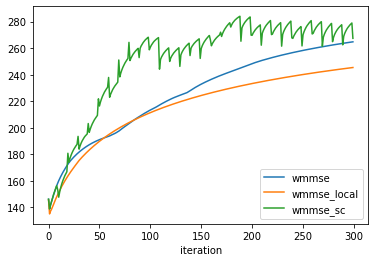

In [54]:
data.groupby('iteration').mean().plot();

In [58]:
data.to_csv(f'data/{netB_power_training_mode}_{netB_power_testing_mode}_{max_round}r.csv', index=False)